In [1]:
# Data management
import pandas as pd
import numpy as np

# Visualizaiton 
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import CategoricalDtype

# Stats
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import pingouin as pg

# analysis goal
- T1 & T3 psychiatric score correlation: strong for both BDI & PVSS 
- T1 to T3 retention rate: 51.69%
- retention vs non-retention psychiatric distribution: no group differences

ug_t3_clean data note (older note)
- screened RT 
- checked for complete BDI and PVSS score
- added demographics details 
- treated T3 as a standalone dataset (not as T1 retention)

Note
- only used baseline psyscore for labels (everything is mapped from the baseline max n demographics, including the symptoms cutoff from baseline)

In [2]:
# baseline UG data load
ug_t1 = pd.read_csv('../data/LEAP_baseline_ug_n236_analysis.csv') #copied raw to data folder
psy_t1_raw = pd.read_csv('../data/raw/LEAP_baseline_survey.csv') #copied raw to data folder

# clean T2 data load
# ug_t2 = pd.read_csv('./data/LEAP_week1_ug_n168_analysis.csv') #copied raw to data folder

# clean T3 data load
ug_t3 = pd.read_csv('../data/LEAP_month1_ug_n129_analysis.csv') #copied raw to data folder
psy_t3_raw = pd.read_csv('../data/raw/LEAP_month1_survey.csv') #copied raw to data folder

In [3]:
# baseline RL data load
rl_t1 = pd.read_csv('../data/LEAP_baseline_rl_n220_analysis.csv') #copied raw to data folder

# clean T3 data load
rl_t3 = pd.read_csv('../data/LEAP_month1_rl_n125_analysis.csv') #copied raw to data folder

In [4]:
# prep psych data
psy_t1 = psy_t1_raw[['prolific_pid', 'bdi_total', 'pvss_total']]
psy_t1.rename(columns={'prolific_pid': 'participant'}, inplace=True) 

psy_t3 = psy_t3_raw[['prolific_pid', 'bdi_total', 'pvss_total']]
psy_t3.rename(columns={'prolific_pid': 'participant'}, inplace=True) 

# add missing pvss_total to the raw data
ug_t1 = ug_t1.merge(psy_t1[['participant', 'pvss_total']], on='participant', how='left')

C:\Users\fuq01\AppData\Local\Temp\ipykernel_19004\1385835518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psy_t1.rename(columns={'prolific_pid': 'participant'}, inplace=True)
C:\Users\fuq01\AppData\Local\Temp\ipykernel_19004\1385835518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psy_t3.rename(columns={'prolific_pid': 'participant'}, inplace=True)


In [5]:
# Get unique subject IDs from each session
t1_ids = set(ug_t1['participant'].unique())
# t2_ids = set(ug_t2['participant'].unique())
t3_ids = set(ug_t3['participant'].unique())

# Find IDs present in both T1 and T3
common_ids = t1_ids.intersection(t3_ids)

# Find IDs present in T1, T2, and T3
# common_ids_all = t1_ids.intersection(t2_ids).intersection(t3_ids)

# If you want this as a list or DataFrame:
common_ids_list = list(common_ids)
len(common_ids_list)

129

# Sample summary

In [6]:
# Get subject-level unique demographic data
t1_demo = ug_t1.drop_duplicates(subset='participant')

# Sex percentage (female = 2)
sex_percent = (t1_demo['sex'] == 2).mean() * 100

# Age: mean, standard deviation, min, and max
age_mean = t1_demo['age'].mean()
age_std  = t1_demo['age'].std()
age_min  = t1_demo['age'].min()
age_max  = t1_demo['age'].max()

print('Baseline summary')
print(f"Female percentage: {sex_percent:.2f}%")
print(f"Age - Mean: {age_mean:.2f}, SD: {age_std:.2f}, Range: {age_min} to {age_max}")


Baseline summary
Female percentage: 51.69%
Age - Mean: 41.73, SD: 10.00, Range: 27 to 77


In [7]:
# Get subject-level unique demographic data
t3_demo = ug_t3.drop_duplicates(subset='participant')

# Sex percentage (female = 2)
sex_percent = (t3_demo['sex'] == 2).mean() * 100

# Age: mean, standard deviation, min, and max
age_mean = t3_demo['age'].mean()
age_std  = t3_demo['age'].std()
age_min  = t3_demo['age'].min()
age_max  = t3_demo['age'].max()

print('1-month summary')
print(f"Female percentage: {sex_percent:.2f}%")
print(f"Age - Mean: {age_mean:.2f}, SD: {age_std:.2f}, Range: {age_min} to {age_max}")

1-month summary
Female percentage: 51.16%
Age - Mean: 43.27, SD: 10.85, Range: 27.0 to 77.0


In [9]:
t3_demo

,Unnamed: 0.1,Unnamed: 0,participant,trial,offer,choice_key,choice_rt,rating_rt,rating_start,rating,...,total_prior_diag,md_anx_prior_diag,non_md_prior_diag,bdi_total,pvss_total,apathy_score,anxiety_score,group,depression,anhedonia
0,0,0,54e32a60fdf99b3eae9de85b,0.0,5.0,left,2.1515,NaN,12.0,NaN,...,1.0,1.0,0.0,23.0,3.142857,19.0,12.0,Both,1.0,1.0
58,60,0,5590a34cfdf99b729d4f69dc,0.0,5.0,left,2.1831,NaN,20.0,NaN,...,0.0,0.0,0.0,31.0,8.047619,10.0,35.0,Depression,1.0,0.0
118,120,0,5596a991fdf99b2d1e834690,0.0,5.0,left,0.4313,NaN,11.0,NaN,...,0.0,0.0,0.0,0.0,9.000000,4.0,0.0,Healthy,0.0,0.0
178,180,0,55b237e6fdf99b19ea79d2f7,0.0,5.0,left,1.4890,NaN,50.0,NaN,...,4.0,3.0,1.0,35.0,5.523810,13.0,14.0,Both,1.0,1.0
238,240,0,55b508f4fdf99b1c26c21c69,0.0,5.0,left,1.1190,NaN,50.0,NaN,...,2.0,2.0,0.0,44.0,2.000000,23.0,37.0,Both,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7400,8640,0,6361751dc446d0cb7b619da5,0.0,5.0,left,0.4558,NaN,29.0,NaN,...,1.0,0.0,1.0,6.0,6.523810,15.0,26.0,Anhedonia,0.0,1.0
7460,8700,0,63a0d718bbed03d92665039e,0.0,5.0,left,1.0870,NaN,31.0,NaN,...,1.0,1.0,0.0,1.0,8.095238,6.0,8.0,Healthy,0.0,0.0
7520,8820,0,63b6cee06aaa9fc9669b8cc2,0.0,5.0,left,1.3439,NaN,6.0,NaN,...,0.0,0.0,0.0,2.0,7.619048,8.0,16.0,Healthy,0.0,0.0
7579,8880,0,63c34086cb929e7c9b844a67,0.0,5.0,right,0.7473,NaN,44.0,NaN,...,0.0,0.0,0.0,7.0,6.238095,16.0,4.0,Anhedonia,0.0,1.0


# Figure 1

## T1 & T3 psych correlation

In [124]:
# Step 1: Define BDI item columns
bdi_items = [f"bdi_{i:02d}" for i in range(1, 22)]

# Step 2: Extract BDI items and IDs
t1_bdi = psy_t1_raw[['prolific_pid'] + bdi_items].copy()
t3_bdi = psy_t3_raw[['prolific_pid'] + bdi_items].copy()

# Step 3: Drop subjects with missing items
t1_bdi_clean = t1_bdi.dropna(subset=bdi_items)
t3_bdi_clean = t3_bdi.dropna(subset=bdi_items)

# Step 4: Compute Cronbach's alpha separately
alpha_t1, _ = pg.cronbach_alpha(data=t1_bdi_clean[bdi_items])
alpha_t3, _ = pg.cronbach_alpha(data=t3_bdi_clean[bdi_items])

print('BDI item internal consistency')
print(f"Cronbach's alpha at T1: α = {alpha_t1:.2f}")
print(f"Cronbach's alpha at T3: α = {alpha_t3:.2f}")

BDI item internal consistency
Cronbach's alpha at T1: α = 0.94
Cronbach's alpha at T3: α = 0.95


In [125]:
# Step 1: Define PVSS item columns
pvss_items = [f"pvss_{i:01d}" for i in range(1, 21)]  # pvss_01 to pvss_20

# Step 2: Extract PVSS items and IDs
t1_pvss = psy_t1_raw[['prolific_pid'] + pvss_items].copy()
t3_pvss = psy_t3_raw[['prolific_pid'] + pvss_items].copy()

# Step 3: Drop subjects with missing items
t1_pvss_clean = t1_pvss.dropna(subset=pvss_items)
t3_pvss_clean = t3_pvss.dropna(subset=pvss_items)

# Step 4: Compute Cronbach's alpha separately
alpha_t1, _ = pg.cronbach_alpha(data=t1_pvss_clean[pvss_items])
alpha_t3, _ = pg.cronbach_alpha(data=t3_pvss_clean[pvss_items])

print('PVSS item internal consistency')
print(f"Cronbach's alpha at T1: α = {alpha_t1:.2f}")
print(f"Cronbach's alpha at T3: α = {alpha_t3:.2f}")

PVSS item internal consistency
Cronbach's alpha at T1: α = 0.93
Cronbach's alpha at T3: α = 0.94


In [114]:
# Find participants with complete scores at both timepoints 
psy_t1_common = psy_t1[psy_t1['participant'].isin(common_ids)]
psy_t3_common = psy_t3[psy_t3['participant'].isin(common_ids)]

# Merge T1 and T3 data on subject_id
merged = pd.merge(psy_t1_common, psy_t3_common, on='participant', suffixes=('_T1', '_T3'))
merged.dropna(inplace=True)

In [119]:
# Step 1: Reshape from wide to long format
icc_df = merged[['participant', 'bdi_total_T1', 'bdi_total_T3']].melt(
    id_vars='participant',
    value_vars=['bdi_total_T1', 'bdi_total_T3'],
    var_name='timepoint',
    value_name='score'
)

# Step 2: Clean 'timepoint' to be 'T1' and 'T3' (or any two distinct labels)
icc_df['timepoint'] = icc_df['timepoint'].str.extract(r'T(\d)').squeeze()  # gets '1' or '3'

# Step 3: Compute ICC (type = ICC2 for test-retest)
icc_result = pg.intraclass_corr(data=icc_df, targets='participant', raters='timepoint', ratings='score')

# Step 4: Extract ICC2 value
icc2_bdi = icc_result.loc[icc_result['Type'] == 'ICC2', 'ICC'].values[0]
print(f"Intraclass Correlation (ICC2) for BDI total: ICC = {icc2_bdi:.2f}")

Intraclass Correlation (ICC2) for BDI total: ICC = 0.90


In [120]:
# Step 1: Reshape from wide to long format
icc_df = merged[['participant', 'pvss_total_T1', 'pvss_total_T3']].melt(
    id_vars='participant',
    value_vars=['pvss_total_T1', 'pvss_total_T3'],
    var_name='timepoint',
    value_name='score'
)

# Step 2: Clean 'timepoint' to be 'T1' and 'T3' (or any two distinct labels)
icc_df['timepoint'] = icc_df['timepoint'].str.extract(r'T(\d)').squeeze()  # gets '1' or '3'

# Step 3: Compute ICC (type = ICC2 for test-retest)
icc_result = pg.intraclass_corr(data=icc_df, targets='participant', raters='timepoint', ratings='score')

# Step 4: Extract ICC2 value
icc2_pvss = icc_result.loc[icc_result['Type'] == 'ICC2', 'ICC'].values[0]
print(f"Intraclass Correlation (ICC2) for PVSS total: ICC = {icc2_pvss:.2f}")

Intraclass Correlation (ICC2) for PVSS total: ICC = 0.83


df =  120


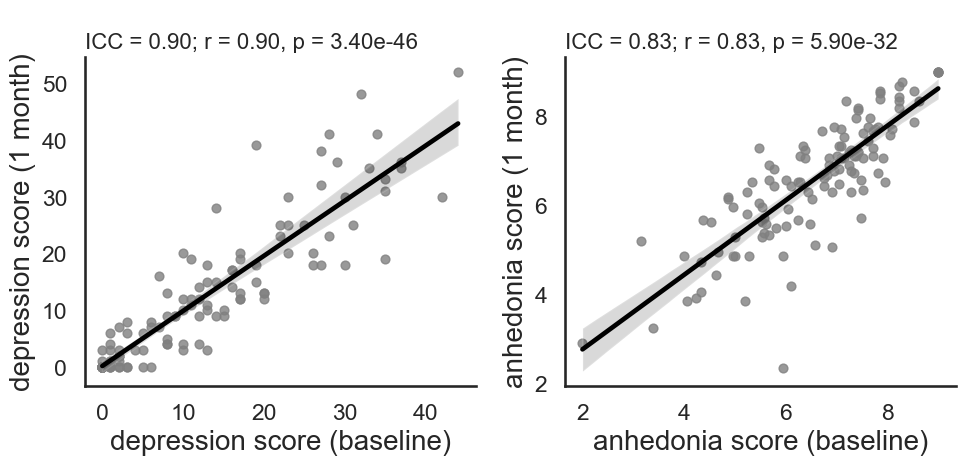

In [121]:
# Figure 1a and 1b

# Set a clean white style with no grid
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# === Panel a: Depression ===
# Cronbach's alpha
df_dep = merged[['bdi_total_T1', 'bdi_total_T3']].dropna()
alpha_dep, _ = pg.cronbach_alpha(data=df_dep)
# Pearson corrrelation
x_dep = merged['bdi_total_T1']
y_dep = merged['bdi_total_T3']
r_dep, p_dep = pearsonr(x_dep, y_dep)
print('df = ', len(x_dep) - 2)
p_dep_text = f"p = {p_dep:.2e}"
# p_dep_text = "p < 0.01" if p_dep < 0.01 else f"p = {p_dep:.2f}"

sns.regplot(x=x_dep, y=y_dep, scatter_kws={"s": 40, "color": "grey"}, line_kws={"color": "black"}, ax=axes[0])
axes[0].set_title(f'\nICC = {icc2_bdi:.2f}; r = {r_dep:.2f}, {p_dep_text}', fontsize=16, loc='left')
# axes[0].set_title(f'\nα = {alpha_dep:.2f}', fontsize=16, loc='left')

axes[0].set_xlabel('depression score (baseline)', fontsize=20)
axes[0].set_ylabel('depression score (1 month)', fontsize=20)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# === Panel b: Anhedonia ===
# Cronbach's alpha
df_anh = merged[['pvss_total_T1', 'pvss_total_T3']].dropna()
alpha_anh, _ = pg.cronbach_alpha(data=df_anh)
# Pearson corrrelation
x_anh = merged['pvss_total_T1']
y_anh = merged['pvss_total_T3']
r_anh, p_anh = pearsonr(x_anh, y_anh)
p_anh_text = f"p = {p_anh:.2e}"
# p_anh_text = "p < 0.01" if p_anh < 0.01 else f"p = {p_anh:.2f}"

sns.regplot(x=x_anh, y=y_anh, scatter_kws={"s": 40, "color": "grey"}, line_kws={"color": "black"}, ax=axes[1])
axes[1].set_title(f'\nICC = {icc2_pvss:.2f}; r = {r_anh:.2f}, {p_anh_text}', fontsize=16, loc='left')
axes[1].set_xlabel('anhedonia score (baseline)', fontsize=20)
axes[1].set_ylabel('anhedonia score (1 month)', fontsize=20)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# save
plt.tight_layout()
plt.savefig('../figure/psy_corr_t1_t3.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Retention status

In [18]:
retention_rate_pct = ug_t3['participant'].nunique() / ug_t1['participant'].nunique()  * 100
print(f"Retention rate: {retention_rate_pct:.2f}%")

Retention rate: 54.66%


In [19]:
# Label retention status 
psy_t1['retention'] = psy_t1['participant'].isin(psy_t1_common['participant'])
psy_t1['retention_label'] = psy_t1['retention'].map({True: 'retained', False: 'not retained', })

retention_order = pd.CategoricalDtype(['retained', 'not retained'], ordered=True)
psy_t1['retention_label'] = psy_t1['retention_label'].astype(retention_order)

psy_t1.head()

,participant,bdi_total,pvss_total,retention,retention_label
0,5d1855f26be726001a39cf9b,3.0,3.285714,False,not retained
1,6101d433c8a23b9b39e41009,35.0,4.000000,False,not retained
2,60fcbc5369b93b4dc6c26e16,1.0,8.285714,False,not retained
3,603595f7c81d8e6ceaa65476,28.0,5.476190,False,not retained
4,56c3ee7411e094000dd4654d,25.0,5.190476,False,not retained


In [20]:
# Retention by depression scores
retained = psy_t1.loc[psy_t1['retention'] == True, 'bdi_total'].dropna()
dropout = psy_t1.loc[psy_t1['retention'] == False, 'bdi_total'].dropna()

# 2 sample independent T-test
t_stat, p_val = ttest_ind(retained, dropout, nan_policy='omit')
df = len(retained) + len(dropout) - 2

print(f"T-test: t({df}) = {t_stat:.2f}, p = {p_val:.4f}")

T-test: t(242) = -0.88, p = 0.3788


In [21]:
# Retention by anhedonia scores
retained = psy_t1[psy_t1['retention'] == True]['pvss_total'].dropna()
dropout  = psy_t1[psy_t1['retention'] == False]['pvss_total'].dropna()

# 2 sample independent T-test
t_stat, p_val = ttest_ind(retained, dropout, nan_policy='omit')
df = len(retained) + len(dropout) - 2

print(f"T-test: t({df}) = {t_stat:.2f}, p = {p_val:.4f}")

T-test: t(251) = 0.25, p = 0.8028


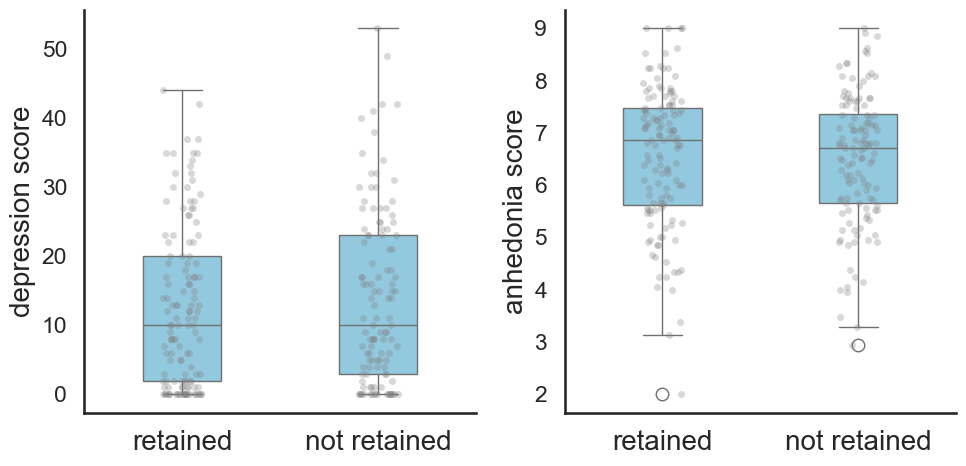

In [22]:
# Figure 1c and 1d

# Set style
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

# Depression
sns.boxplot(data=psy_t1, x='retention_label', y='bdi_total', ax=axes[0], color='skyblue', width=0.4)
sns.stripplot(data=psy_t1, x='retention_label', y='bdi_total', ax=axes[0], color='grey', alpha=0.3)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('depression score', fontsize=20)

# Anhedonia
sns.boxplot(data=psy_t1, x='retention_label', y='pvss_total', ax=axes[1], color='skyblue', width=0.4)
sns.stripplot(data=psy_t1, x='retention_label', y='pvss_total', ax=axes[1], color='grey', alpha=0.3)
axes[1].tick_params(axis='x', labelsize=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('anhedonia score', fontsize=20)

sns.despine()
plt.tight_layout()
plt.savefig('./figure/psy_reten_t1_t3.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Participant distribution by symptom profile

C:\Users\fuq01\AppData\Local\Temp\ipykernel_13688\3024875648.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sub_group_t1.loc[:, 'group'] = sub_group_t1['group'].astype(group_order)
C:\Users\fuq01\AppData\Local\Temp\ipykernel_13688\3024875648.py:17: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sub_group_t3.loc[:, 'group'] = sub_group_t3['group'].astype(group_order)
C:\Users\fuq01\AppData\Local\Temp\ipykernel_13688\3024875648.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_map[x.get_t

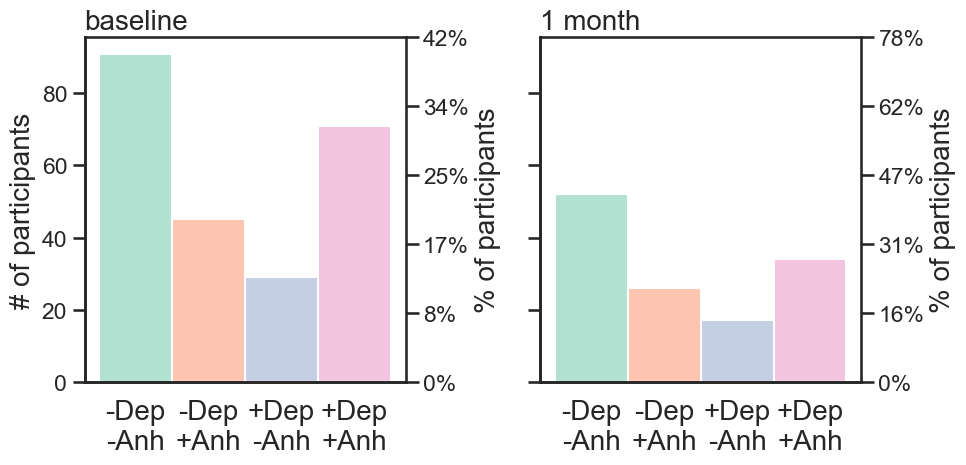

In [25]:
# Figure 1e & 1f

# Set style
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

# Define categorical order
group_order = CategoricalDtype(['Healthy', 'Anhedonia', 'Depression', 'Both'], ordered=True)

# Prepare subgroup T1
sub_group_t1 = ug_t1.drop_duplicates(subset=['participant']).copy()
sub_group_t1.loc[:, 'group'] = sub_group_t1['group'].astype(group_order)
sub_group_t1 = sub_group_t1.sort_values('group')

# Prepare subgroup T3
sub_group_t3 = ug_t3.drop_duplicates(subset=['participant']).copy()
sub_group_t3.loc[:, 'group'] = sub_group_t3['group'].astype(group_order)
sub_group_t3 = sub_group_t3.sort_values('group')

# Label map for x-axis
label_map = {'Healthy': '-Dep\n-Anh', 'Anhedonia': '-Dep\n+Anh', 'Depression': '+Dep\n-Anh', 'Both': '+Dep\n+Anh'}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Function to plot with secondary axis
def dual_axis_histplot(ax, data, title, total_count):
    sns.histplot(data=data, x="group", stat='count', hue='group',
                 palette='Set2', legend=False, ax=ax)
    ax.set_title(title, loc='left', fontsize=20)
    ax.set_xlabel('')
    ax.set_ylabel('# of participants', fontsize=20)
    ax.set_xticklabels([label_map[x.get_text()] for x in ax.get_xticklabels()], fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Secondary axis for percentage
    ax2 = ax.twinx()
    ticks = ax.get_yticks()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ticks)
    ax2.set_yticklabels([f'{tick / total_count * 100:.0f}%' for tick in ticks])
    ax2.set_ylabel('% of participants', fontsize=20)

# Panel: T1
dual_axis_histplot(axes[0], sub_group_t1, 'baseline', len(sub_group_t1))

# Panel: T3
dual_axis_histplot(axes[1], sub_group_t3, '1 month', len(sub_group_t3))
axes[1].set_ylabel('')  # prevent duplicate y-label

plt.tight_layout()
plt.savefig('./figure/psy_group_t1_t3.jpg', dpi=300, bbox_inches='tight')
plt.show()

ug_t3_clean data note (older note)
- screened RT 
- checked for complete BDI and PVSS score
- added demographics details 
- treated T3 as a standalone dataset (not as T1 retention)

# Figure 2

## UG subject level

In [91]:
from matplotlib.ticker import FuncFormatter

def fixed_width_formatter(x, _):
    return f"{x: .2f}"  # + sign, 3 decimal places, fixed width


In [6]:
# baseline & 1 month common behavior correlation
psy_t1_common_beh = ug_t1.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()
psy_t3_common_beh = ug_t3.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_19004\2813559951.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  psy_t1_common_beh = ug_t1.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()
C:\Users\fuq01\AppData\Local\Temp\ipykernel_19004\2813559951.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  psy_t3_common_beh = ug_t3.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()


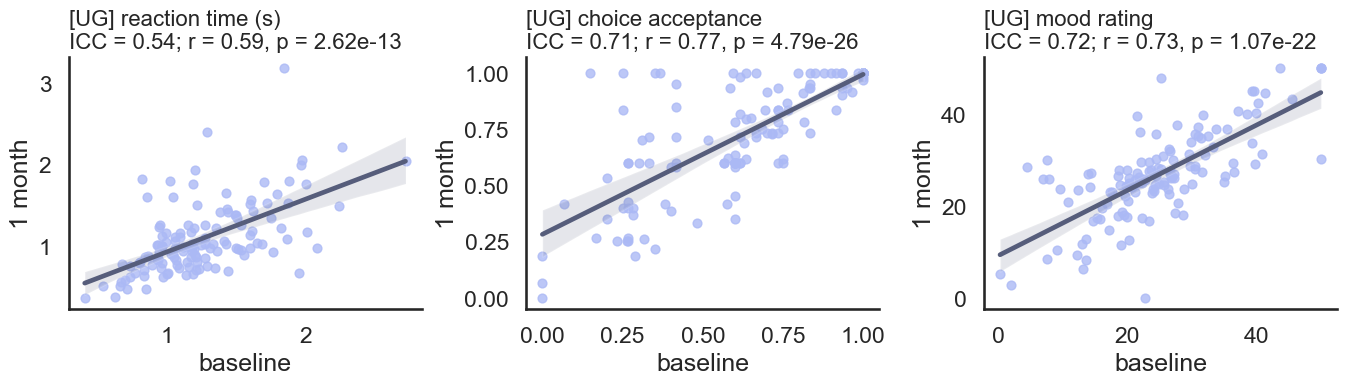

In [7]:
# Fig 2 a & b & c

# Set a clean white style with no grid
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

# Merge T1 and T3 data on subject_id
merged = pd.merge(psy_t1_common_beh, psy_t3_common_beh, on='participant', suffixes=('_T1', '_T3'))
merged.dropna(inplace=True)

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))

# === Panel: RT ===
x_rt = merged['choice_rt_T1']
y_rt = merged['choice_rt_T3']

# ICC
df_rt_long = merged[['participant', 'choice_rt_T1', 'choice_rt_T3']].melt(
    id_vars='participant', var_name='timepoint', value_name='score')
df_rt_long['timepoint'] = df_rt_long['timepoint'].str.extract(r'T(\d)').squeeze()
icc_rt = pg.intraclass_corr(data=df_rt_long, targets='participant', raters='timepoint', ratings='score')
icc_rt_val = icc_rt.loc[icc_rt['Type'] == 'ICC2', 'ICC'].values[0]

# Pearson r
r_rt, p_rt = pearsonr(x_rt, y_rt)
p_rt_text = f"p = {p_rt:.2e}"

sns.regplot(x=x_rt, y=y_rt, scatter_kws={"s": 40, "color": "#abb9f5"},
            line_kws={"color": "#565d7b"}, ax=axes[0])
axes[0].set_title(f'[UG] reaction time (s) \nICC = {icc_rt_val:.2f}; r = {r_rt:.2f}, {p_rt_text}',
                  fontsize=16, loc='left')
axes[0].set_xlabel('baseline')
axes[0].set_ylabel('1 month')

# === Panel: choice ===
x_ca = merged['choice_acc_T1']
y_ca = merged['choice_acc_T3']

df_ca_long = merged[['participant', 'choice_acc_T1', 'choice_acc_T3']].melt(
    id_vars='participant', var_name='timepoint', value_name='score')
df_ca_long['timepoint'] = df_ca_long['timepoint'].str.extract(r'T(\d)').squeeze()
icc_ca = pg.intraclass_corr(data=df_ca_long, targets='participant', raters='timepoint', ratings='score')
icc_ca_val = icc_ca.loc[icc_ca['Type'] == 'ICC2', 'ICC'].values[0]

r_ca, p_ca = pearsonr(x_ca, y_ca)
p_ca_text = f"p = {p_ca:.2e}"

sns.regplot(x=x_ca, y=y_ca, scatter_kws={"s": 40, "color": "#abb9f5"},
            line_kws={"color": "#565d7b"}, ax=axes[1])
axes[1].set_title(f'[UG] choice acceptance \nICC = {icc_ca_val:.2f}; r = {r_ca:.2f}, {p_ca_text}',
                  fontsize=16, loc='left')
axes[1].set_xlabel('baseline')
axes[1].set_ylabel('1 month')

# === Panel: mood ===
x_m = merged['rating_T1']
y_m = merged['rating_T3']

df_m_long = merged[['participant', 'rating_T1', 'rating_T3']].melt(
    id_vars='participant', var_name='timepoint', value_name='score')
df_m_long['timepoint'] = df_m_long['timepoint'].str.extract(r'T(\d)').squeeze()
icc_m = pg.intraclass_corr(data=df_m_long, targets='participant', raters='timepoint', ratings='score')
icc_m_val = icc_m.loc[icc_m['Type'] == 'ICC2', 'ICC'].values[0]

r_m, p_m = pearsonr(x_m, y_m)
p_m_text = f"p = {p_m:.2e}"

sns.regplot(x=x_m, y=y_m, scatter_kws={"s": 40, "color": "#abb9f5"},
            line_kws={"color": "#565d7b"}, ax=axes[2])
axes[2].set_title(f'[UG] mood rating \nICC = {icc_m_val:.2f}; r = {r_m:.2f}, {p_m_text}',
                  fontsize=16, loc='left')
axes[2].set_xlabel('baseline')
axes[2].set_ylabel('1 month')

# save
sns.despine()
plt.tight_layout()
plt.savefig('../figure/T1T3_corr_beh.jpg', dpi=300, bbox_inches='tight')
plt.show()

## Behavior by offer size

In [60]:
ug_t1_common = ug_t1[ug_t1['participant'].isin(common_ids_all)].copy()
# ug_t2_common = ug_t2[ug_t2['participant'].isin(common_ids_all)].copy()
ug_t3_common = ug_t3[ug_t3['participant'].isin(common_ids_all)].copy()

In [61]:
ug_t1_common['timepoint'] = 'baseline'
# ug_t2_common['timepoint'] = '1 week'
ug_t3_common['timepoint'] = '1 month'

In [62]:
ug_t1_t3 = pd.concat([ug_t1_common, ug_t3_common], ignore_index=True)
ug_t1_t3

,Unnamed: 0.1,participant,age,sex,gender,edu_level,ladder_us,queer,income,income_order,...,choice_rej,choice_acc,offer_bin,rating_z,rating_delta,rating_fill,log_rt,pvss_total_y,timepoint,pvss_total
0,120,6078163f1e585e4f71e3b879,61.0,2.0,2.0,4.0,4.0,0.0,"$100,000",10.0,...,0.0,1.0,Medium,NaN,NaN,NaN,0.282921,4.238095,baseline,NaN
1,121,6078163f1e585e4f71e3b879,61.0,2.0,2.0,4.0,4.0,0.0,"$100,000",10.0,...,0.0,1.0,Medium,1.027527,15.0,15.0,0.207827,4.238095,baseline,NaN
2,122,6078163f1e585e4f71e3b879,61.0,2.0,2.0,4.0,4.0,0.0,"$100,000",10.0,...,0.0,1.0,High,NaN,NaN,15.0,0.005982,4.238095,baseline,NaN
3,123,6078163f1e585e4f71e3b879,61.0,2.0,2.0,4.0,4.0,0.0,"$100,000",10.0,...,0.0,1.0,Low,NaN,NaN,15.0,0.368109,4.238095,baseline,NaN
4,124,6078163f1e585e4f71e3b879,61.0,2.0,2.0,4.0,4.0,0.0,"$100,000",10.0,...,0.0,1.0,Low,-2.193910,NaN,15.0,0.508623,4.238095,baseline,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15398,9055,63d1c1b521f75a8a9f14160f,51.0,2.0,2.0,6.0,5.0,0.0,"$90,000",9.0,...,0.0,1.0,High,NaN,NaN,5.0,1.448095,NaN,1 month,5.333333
15399,9056,63d1c1b521f75a8a9f14160f,51.0,2.0,2.0,6.0,5.0,0.0,"$90,000",9.0,...,1.0,0.0,Medium,-1.206186,-30.0,-30.0,1.013635,NaN,1 month,5.333333
15400,9057,63d1c1b521f75a8a9f14160f,51.0,2.0,2.0,6.0,5.0,0.0,"$90,000",9.0,...,1.0,0.0,Medium,NaN,NaN,-30.0,0.795117,NaN,1 month,5.333333
15401,9058,63d1c1b521f75a8a9f14160f,51.0,2.0,2.0,6.0,5.0,0.0,"$90,000",9.0,...,1.0,0.0,Low,NaN,NaN,-30.0,1.184392,NaN,1 month,5.333333


In [63]:
ug_t1_t3_sub = ug_t1_t3.groupby(['timepoint', 'participant', 'offer'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_21348\2638393256.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ug_t1_t3_sub = ug_t1_t3.groupby(['timepoint', 'participant', 'offer'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()


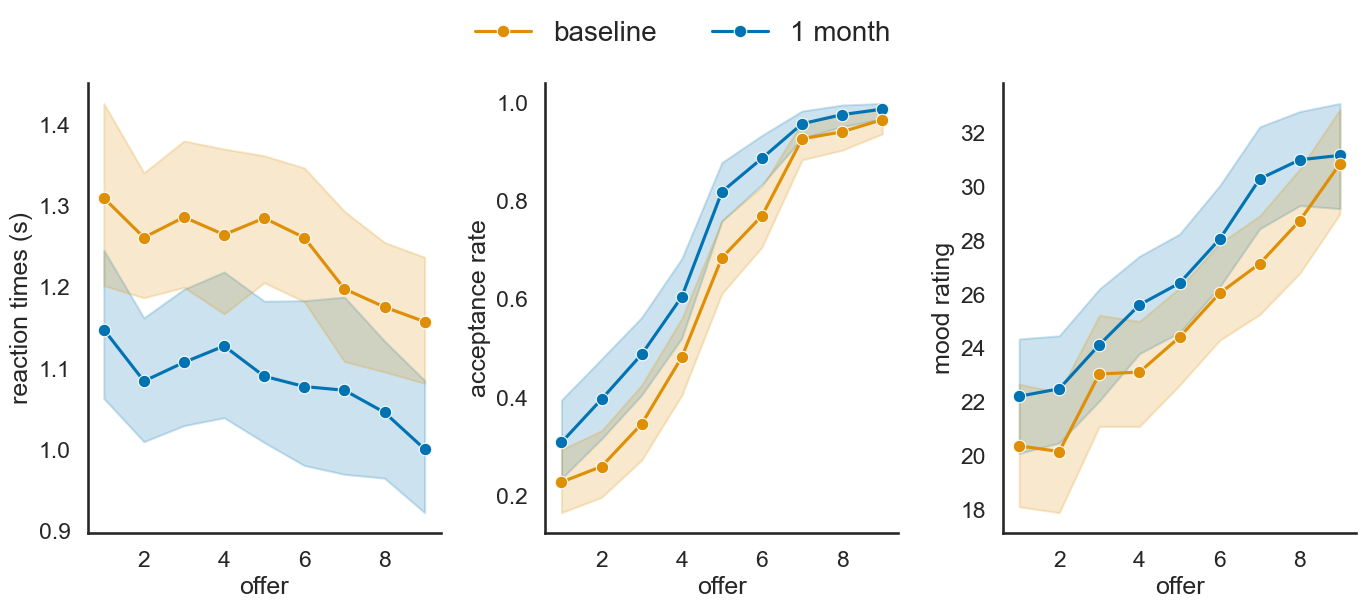

In [80]:
# Set a clean white style with no grid
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True)

# Panel: Reaction Times
plot_a = sns.lineplot(data=ug_t1_t3_sub, x='offer', y='choice_rt', hue='timepoint', errorbar=('ci', 95),
                        ax=axes[0], marker='o', legend=True)  # allow handles to be created
axes[0].set_ylabel('reaction times (s)')
axes[0].set_xlabel('offer')
axes[0].legend_.remove()  # removes panel legend from view

# Panel: Acceptance Rate
sns.lineplot(data=ug_t1_t3_sub, x='offer', y='choice_acc', hue='timepoint', errorbar=('ci', 95),
                        ax=axes[1], marker='o', legend=False)
axes[1].set_ylabel('acceptance rate')
axes[1].set_xlabel('offer')

# Panel: Mood Rating
sns.lineplot(data=ug_t1_t3_sub, x='offer', y='rating', hue='timepoint', errorbar=('ci', 95),
    ax=axes[2], marker='o', legend=False)
axes[2].set_ylabel('mood rating')
axes[2].set_xlabel('offer')

# Global legend from the first plot
handles, labels = plot_a.get_legend_handles_labels()
ordered_handles = [handles[labels.index('baseline')], handles[labels.index('1 month')]]
ordered_labels = ['baseline', '1 month']
fig.legend(ordered_handles, ordered_labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),  # move legend higher up
            ncol=3, frameon=False, fontsize=20)

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./figure/fig_ug_beh_long.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
ug_t3['participant'].nunique()

129

## RL subject level

In [8]:
rl_t1.columns

Index(['Unnamed: 0', 'participant', 'trial', 'block', 'block_type', 'action',
       'reward', 'rt', 'choice', 'opt_act', 'optimal', 'age', 'sex', 'gender',
       'edu_level', 'ladder_us', 'queer', 'income', 'income_order', 'race',
       'total_prior_diag', 'md_anx_prior_diag', 'non_md_prior_diag',
       'bdi_total', 'pvss_total', 'apathy_score', 'anxiety_score', 'group',
       'depression', 'anhedonia', 'log_rt'],
      dtype='object')

In [9]:
# baseline & 1 month common behavior correlation
t1_common_beh = rl_t1.groupby(['participant', 'block_type'])['rt', 'optimal'].mean().reset_index()
t3_common_beh = rl_t3.groupby(['participant', 'block_type'])['rt', 'optimal'].mean().reset_index()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_19004\930169032.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  t1_common_beh = rl_t1.groupby(['participant', 'block_type'])['rt', 'optimal'].mean().reset_index()
C:\Users\fuq01\AppData\Local\Temp\ipykernel_19004\930169032.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  t3_common_beh = rl_t3.groupby(['participant', 'block_type'])['rt', 'optimal'].mean().reset_index()


In [10]:
# Merge T1 and T3 data on subject_id
merged = pd.merge(t1_common_beh, t3_common_beh, on='participant', suffixes=('_T1', '_T3'))
merged.dropna(inplace=True)
merged

,participant,block_type_T1,rt_T1,optimal_T1,block_type_T3,rt_T3,optimal_T3
0,5590a34cfdf99b729d4f69dc,numberbar_mixed,0.965636,0.787879,numberbar_mixed,1.033429,0.742857
1,5590a34cfdf99b729d4f69dc,numberbar_mixed,0.965636,0.787879,numberbar_neg,1.240594,0.593750
2,5590a34cfdf99b729d4f69dc,numberbar_mixed,0.965636,0.787879,numberbar_pos,1.134000,0.800000
3,5590a34cfdf99b729d4f69dc,numberbar_neg,0.666929,0.642857,numberbar_mixed,1.033429,0.742857
4,5590a34cfdf99b729d4f69dc,numberbar_neg,0.666929,0.642857,numberbar_neg,1.240594,0.593750
...,...,...,...,...,...,...,...
1066,63d1c1b521f75a8a9f14160f,numberbar_neg,1.346588,0.617647,numberbar_neg,1.266735,0.823529
1067,63d1c1b521f75a8a9f14160f,numberbar_neg,1.346588,0.617647,numberbar_pos,1.060939,0.696970
1068,63d1c1b521f75a8a9f14160f,numberbar_pos,0.490235,0.647059,numberbar_mixed,0.859967,0.766667
1069,63d1c1b521f75a8a9f14160f,numberbar_pos,0.490235,0.647059,numberbar_neg,1.266735,0.823529


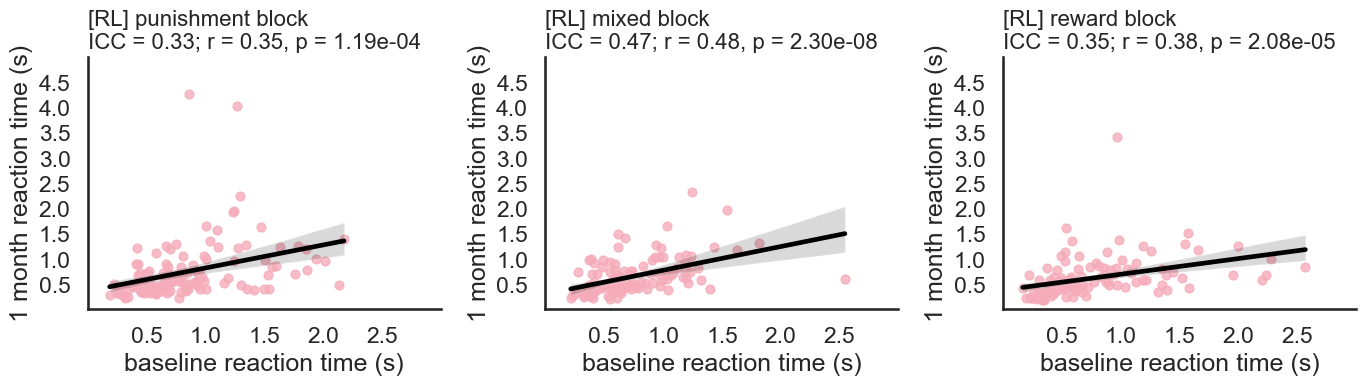

In [11]:
# Fig 2 a & b & c

# Set a clean white style with no grid
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))

# === Panel: RT negative block ===
merged_neg = merged[(merged['block_type_T1'] == 'numberbar_neg') & (merged['block_type_T3'] == 'numberbar_neg')]

x_rt = merged_neg['rt_T1']
y_rt = merged_neg['rt_T3']

df_rt_long = merged_neg[['participant', 'rt_T1', 'rt_T3']].melt(
    id_vars='participant', var_name='timepoint', value_name='score')
df_rt_long['timepoint'] = df_rt_long['timepoint'].str.extract(r'T(\d)').squeeze()
icc_rt_neg = pg.intraclass_corr(data=df_rt_long, targets='participant', raters='timepoint', ratings='score')
icc_rt_val = icc_rt_neg.loc[icc_rt_neg['Type'] == 'ICC2', 'ICC'].values[0]

r_rt, p_rt = pearsonr(x_rt, y_rt)
p_rt_text = f"p = {p_rt:.2e}"

sns.regplot(x=x_rt, y=y_rt, scatter_kws={"s": 40, "color": "#f5abb9"},
            line_kws={"color": "black"}, ax=axes[0])
axes[0].set_title(f'[RL] punishment block \nICC = {icc_rt_val:.2f}; r = {r_rt:.2f}, {p_rt_text}', fontsize=16, loc='left')
axes[0].set_xlabel('baseline reaction time (s)')
axes[0].set_ylabel('1 month reaction time (s)')

# === Panel: RT mixed block ===
merged_mix = merged[(merged['block_type_T1'] == 'numberbar_mixed') & (merged['block_type_T3'] == 'numberbar_mixed')]

x_ca = merged_mix['rt_T1']
y_ca = merged_mix['rt_T3']

df_ca_long = merged_mix[['participant', 'rt_T1', 'rt_T3']].melt(
    id_vars='participant', var_name='timepoint', value_name='score')
df_ca_long['timepoint'] = df_ca_long['timepoint'].str.extract(r'T(\d)').squeeze()
icc_rt_mix = pg.intraclass_corr(data=df_ca_long, targets='participant', raters='timepoint', ratings='score')
icc_mix_val = icc_rt_mix.loc[icc_rt_mix['Type'] == 'ICC2', 'ICC'].values[0]

r_ca, p_ca = pearsonr(x_ca, y_ca)
p_ca_text = f"p = {p_ca:.2e}"

sns.regplot(x=x_ca, y=y_ca, scatter_kws={"s": 40, "color": "#f5abb9"},
            line_kws={"color": "black"}, ax=axes[1])
axes[1].set_title(f'[RL] mixed block \nICC = {icc_mix_val:.2f}; r = {r_ca:.2f}, {p_ca_text}', fontsize=16, loc='left')
axes[1].set_xlabel('baseline reaction time (s)')
axes[1].set_ylabel('1 month reaction time (s)')

# === Panel: RT positive block ===
merged_pos = merged[(merged['block_type_T1'] == 'numberbar_pos') & (merged['block_type_T3'] == 'numberbar_pos')]

x_m = merged_pos['rt_T1']
y_m = merged_pos['rt_T3']

df_m_long = merged_pos[['participant', 'rt_T1', 'rt_T3']].melt(
    id_vars='participant', var_name='timepoint', value_name='score')
df_m_long['timepoint'] = df_m_long['timepoint'].str.extract(r'T(\d)').squeeze()
icc_rt_pos = pg.intraclass_corr(data=df_m_long, targets='participant', raters='timepoint', ratings='score')
icc_pos_val = icc_rt_pos.loc[icc_rt_pos['Type'] == 'ICC2', 'ICC'].values[0]

r_m, p_m = pearsonr(x_m, y_m)
p_m_text = f"p = {p_m:.2e}"

sns.regplot(x=x_m, y=y_m, scatter_kws={"s": 40, "color": "#f5abb9"},
            line_kws={"color": "black"}, ax=axes[2])
axes[2].set_title(f'[RL] reward block \nICC = {icc_pos_val:.2f}; r = {r_m:.2f}, {p_m_text}', fontsize=16, loc='left')
axes[2].set_xlabel('baseline reaction time (s)')
axes[2].set_ylabel('1 month reaction time (s)')

# Set same y-lim and ticks for all panels
for ax in axes:
    ax.set_ylim(0, 5)
    ax.set_yticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])
    ax.set_xlim(0, 3)
    ax.set_xticks([0.5, 1, 1.5, 2, 2.5])

# save
sns.despine()
plt.tight_layout()
plt.savefig('../figure/T1T3_corr_beh_rl_rt.jpg', dpi=300, bbox_inches='tight')
plt.show()

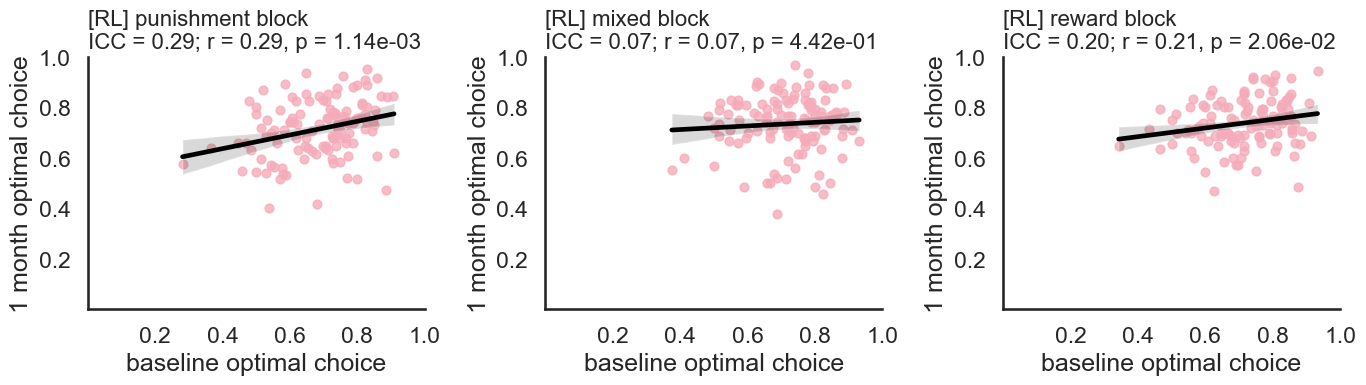

In [12]:
# Fig 2 a & b & c

# Set a clean white style with no grid
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))

# === Panel: RT negative block ===
merged_neg = merged[(merged['block_type_T1'] == 'numberbar_neg') & (merged['block_type_T3'] == 'numberbar_neg')]
x_rt = merged_neg['optimal_T1']
y_rt = merged_neg['optimal_T3']

df_rt_long = merged_neg[['participant', 'optimal_T1', 'optimal_T3']].melt(
    id_vars='participant', var_name='timepoint', value_name='score')
df_rt_long['timepoint'] = df_rt_long['timepoint'].str.extract(r'T(\d)').squeeze()
icc_rt = pg.intraclass_corr(data=df_rt_long, targets='participant', raters='timepoint', ratings='score')
icc_rt_val = icc_rt.loc[icc_rt['Type'] == 'ICC2', 'ICC'].values[0]

r_rt, p_rt = pearsonr(x_rt, y_rt)
p_rt_text = f"p = {p_rt:.2e}"

sns.regplot(x=x_rt, y=y_rt, scatter_kws={"s": 40, "color": "#f5abb9"}, line_kws={"color": "black"}, ax=axes[0])
axes[0].set_title(f'[RL] punishment block \nICC = {icc_rt_val:.2f}; r = {r_rt:.2f}, {p_rt_text}', fontsize=16, loc='left')
axes[0].set_xlabel('baseline optimal choice')
axes[0].set_ylabel('1 month optimal choice')

# === Panel: RT mixed block ===
merged_mix = merged[(merged['block_type_T1'] == 'numberbar_mixed') & (merged['block_type_T3'] == 'numberbar_mixed')]
x_ca = merged_mix['optimal_T1']
y_ca = merged_mix['optimal_T3']

df_ca_long = merged_mix[['participant', 'optimal_T1', 'optimal_T3']].melt(
    id_vars='participant', var_name='timepoint', value_name='score')
df_ca_long['timepoint'] = df_ca_long['timepoint'].str.extract(r'T(\d)').squeeze()
icc_ca = pg.intraclass_corr(data=df_ca_long, targets='participant', raters='timepoint', ratings='score')
icc_ca_val = icc_ca.loc[icc_ca['Type'] == 'ICC2', 'ICC'].values[0]

r_ca, p_ca = pearsonr(x_ca, y_ca)
p_ca_text = f"p = {p_ca:.2e}"

sns.regplot(x=x_ca, y=y_ca, scatter_kws={"s": 40, "color": "#f5abb9"}, line_kws={"color": "black"}, ax=axes[1])
axes[1].set_title(f'[RL] mixed block \nICC = {icc_ca_val:.2f}; r = {r_ca:.2f}, {p_ca_text}', fontsize=16, loc='left')
axes[1].set_xlabel('baseline optimal choice')
axes[1].set_ylabel('1 month optimal choice')

# === Panel: RT positive block ===
merged_pos = merged[(merged['block_type_T1'] == 'numberbar_pos') & (merged['block_type_T3'] == 'numberbar_pos')]
x_m = merged_pos['optimal_T1']
y_m = merged_pos['optimal_T3']

df_m_long = merged_pos[['participant', 'optimal_T1', 'optimal_T3']].melt(
    id_vars='participant', var_name='timepoint', value_name='score')
df_m_long['timepoint'] = df_m_long['timepoint'].str.extract(r'T(\d)').squeeze()
icc_m = pg.intraclass_corr(data=df_m_long, targets='participant', raters='timepoint', ratings='score')
icc_m_val = icc_m.loc[icc_m['Type'] == 'ICC2', 'ICC'].values[0]

r_m, p_m = pearsonr(x_m, y_m)
p_m_text = f"p = {p_m:.2e}"

sns.regplot(x=x_m, y=y_m, scatter_kws={"s": 40, "color": "#f5abb9"}, line_kws={"color": "black"}, ax=axes[2])
axes[2].set_title(f'[RL] reward block \nICC = {icc_m_val:.2f}; r = {r_m:.2f}, {p_m_text}', fontsize=16, loc='left')
axes[2].set_xlabel('baseline optimal choice')
axes[2].set_ylabel('1 month optimal choice')

# Set same y-lim and ticks for all panels
for ax in axes:
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xlim(0, 1)
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1])

# save
sns.despine()
plt.tight_layout()
plt.savefig('../figure/T1T3_corr_beh_rl_choice.jpg', dpi=300, bbox_inches='tight')
plt.show()

### archive week 1

In [27]:
# baseline & 1 week common behavior correlation
psy_t1_common_beh = ug_t1.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()
psy_t2_common_beh = ug_t2.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_32372\999212211.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  psy_t1_common_beh = ug_t1.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()
C:\Users\fuq01\AppData\Local\Temp\ipykernel_32372\999212211.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  psy_t2_common_beh = ug_t2.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()


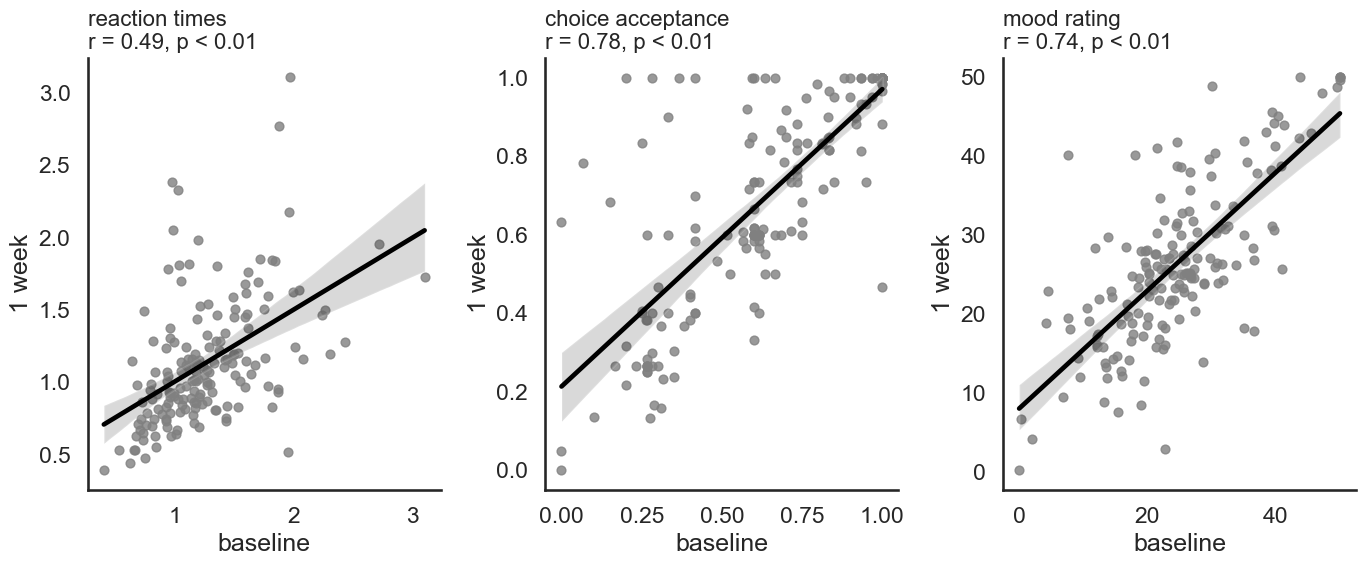

In [ ]:
# Set a clean white style with no grid
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

# Merge T1 and T2 data on subject_id
merged = pd.merge(psy_t1_common_beh, psy_t2_common_beh, on='participant', suffixes=('_T1', '_T2'))
merged.dropna(inplace=True)

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# === Panel d: RT ===
x_rt = merged['choice_rt_T1']
y_rt = merged['choice_rt_T2']
r_rt, p_rt = pearsonr(x_rt, y_rt)
p_rt_text = "p < 0.01" if p_rt < 0.01 else f"p = {p_rt:.2f}"

sns.regplot(x=x_rt, y=y_rt, scatter_kws={"s": 40, "color": "grey"}, line_kws={"color": "black"}, ax=axes[0])
axes[0].set_title(f'reaction times \nr = {r_rt:.2f}, {p_rt_text}', fontsize=16, loc='left')
# axes[0].set_title('a', fontsize=20, loc='left')
axes[0].set_xlabel('baseline')
axes[0].set_ylabel('1 week')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# === Panel e: choice ===
x_ca = merged['choice_acc_T1']
y_ca = merged['choice_acc_T2']
r_ca, p_ca = pearsonr(x_ca, y_ca)
p_ca_text = "p < 0.01" if p_ca < 0.01 else f"p = {p_ca:.2f}"

sns.regplot(x=x_ca, y=y_ca, scatter_kws={"s": 40, "color": "grey"}, line_kws={"color": "black"}, ax=axes[1])
axes[1].set_title(f'choice acceptance \nr = {r_ca:.2f}, {p_ca_text}', fontsize=16, loc='left')
axes[1].set_xlabel('baseline')
axes[1].set_ylabel('1 week')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# === Panel f: mood ===
x_m = merged['rating_T1']
y_m = merged['rating_T2']
r_m, p_m = pearsonr(x_m, y_m)
p_m_text = "p < 0.01" if p_m < 0.01 else f"p = {p_m:.2f}"

sns.regplot(x=x_m, y=y_m, scatter_kws={"s": 40, "color": "grey"}, line_kws={"color": "black"}, ax=axes[2])
axes[2].set_title(f'mood rating \nr = {r_m:.2f}, {p_m_text}', fontsize=16, loc='left')
axes[2].set_xlabel('baseline')
axes[2].set_ylabel('1 week')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# save
plt.tight_layout()
plt.savefig('./figure/psy_corr_beh_T12.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# baseline & 1 month common behavior correlation
psy_t1_common_beh = ug_t1.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()
psy_t3_common_beh = ug_t3.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()
psy_t1_common_beh

C:\Users\fuq01\AppData\Local\Temp\ipykernel_32372\1810495263.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  psy_t1_common_beh = ug_t1.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()
C:\Users\fuq01\AppData\Local\Temp\ipykernel_32372\1810495263.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  psy_t3_common_beh = ug_t3.groupby(['participant'])['choice_rt', 'choice_acc', 'rating'].mean().reset_index()


,participant,choice_rt,choice_acc,rating
0,54847f1cfdf99b07b28f22f9,1.259339,1.000000,25.200000
1,54e32a60fdf99b3eae9de85b,2.716428,1.000000,23.842105
2,559002fefdf99b3f7aada38f,1.674535,0.533333,17.200000
3,5590a34cfdf99b729d4f69dc,1.875777,0.633333,29.880349
4,5596a991fdf99b2d1e834690,1.057870,0.733333,43.700000
...,...,...,...,...
231,63ae31ff5c725a41082afc56,1.486314,0.525424,24.653063
232,63b6cee06aaa9fc9669b8cc2,0.943787,0.150000,39.700000
233,63c34086cb929e7c9b844a67,0.930463,0.233333,9.174225
234,63d15717bf9f5277f27bbe5e,1.370050,0.300000,23.417035


In [64]:
merged['choice_rt_T1'].mean(), merged['choice_rt_T3'].mean()

(1.364877222223256, 1.0866288592218414)

In [62]:
from scipy.stats import ttest_rel
# Paired t-test (only on complete pairs)
t_stat, p_value = ttest_rel(merged['choice_rt_T1'], merged['choice_rt_T3'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 5.516740535872861, P-value: 1.8353493904881546e-07


In [49]:
# Paired t-test (only on complete pairs)
t_stat, p_value = ttest_rel(merged['choice_acc_T1'], merged['choice_acc_T3'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -6.1611869134813855, P-value: 8.677253421102344e-09


In [50]:
# Paired t-test (only on complete pairs)
t_stat, p_value = ttest_rel(merged['rating_T1'], merged['rating_T3'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -3.108331238377146, P-value: 0.002318774479523936


C:\Users\fuq01\AppData\Local\Temp\ipykernel_23916\3084109512.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ug_t1_t3_sub_bdi = ug_t1_t3.groupby(['timepoint', 'participant'])['choice_rt', 'choice_acc', 'rating', 'bdi_total'].mean().reset_index()


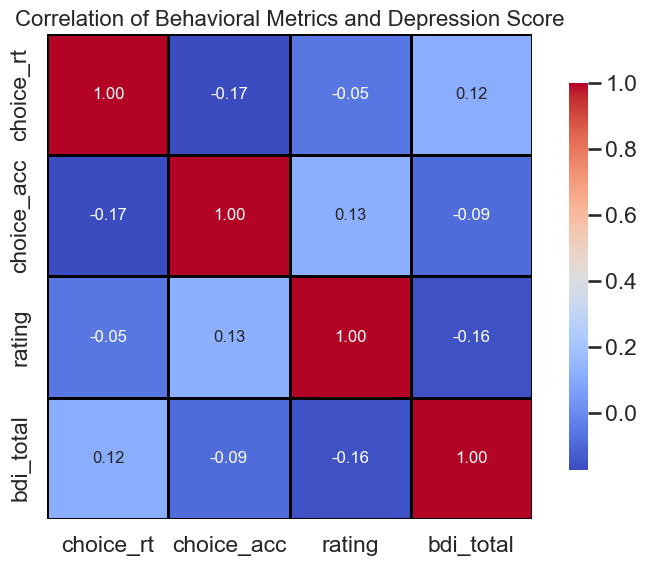

In [51]:
ug_t1_t3_sub_bdi = ug_t1_t3.groupby(['timepoint', 'participant'])['choice_rt', 'choice_acc', 'rating', 'bdi_total'].mean().reset_index()
# Calculate correlation matrix for the selected columns
corr_data = ug_t1_t3_sub_bdi[['choice_rt', 'choice_acc', 'rating', 'bdi_total']]

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,         # Show the correlation values
    cmap='coolwarm',    # Color map
    fmt='.2f',          # Format for the correlation numbers
    cbar_kws={'shrink': 0.8},  # Adjust the colorbar size
    annot_kws={"size": 12},  # Font size for annotation
    square=True,        # Square shape for better visualization
    linewidths=1,       # Line width between cells
    linecolor='black'   # Black lines separating cells
)

# Set labels and title
plt.title('Correlation of Behavioral Metrics and Depression Score', fontsize=16)
plt.tight_layout()
plt.show()

In [52]:
ug_t1_t3_sub

,timepoint,participant,offer,choice_rt,choice_acc,rating
0,1 month,54e32a60fdf99b3eae9de85b,1.0,1.380700,1.000000,5.00
1,1 month,54e32a60fdf99b3eae9de85b,2.0,0.824640,1.000000,22.75
2,1 month,54e32a60fdf99b3eae9de85b,3.0,1.786683,1.000000,25.00
3,1 month,54e32a60fdf99b3eae9de85b,4.0,1.304938,1.000000,21.75
4,1 month,54e32a60fdf99b3eae9de85b,5.0,2.060725,1.000000,26.50
...,...,...,...,...,...,...
2317,baseline,63d1c1b521f75a8a9f14160f,5.0,1.276325,0.083333,27.00
2318,baseline,63d1c1b521f75a8a9f14160f,6.0,1.498538,0.750000,29.00
2319,baseline,63d1c1b521f75a8a9f14160f,7.0,0.895267,1.000000,44.00
2320,baseline,63d1c1b521f75a8a9f14160f,8.0,1.594417,1.000000,35.50


# Figure 3

In [143]:
ug_palette = {
    'low': '#abb9f5',
    "high": '#565d7b'
}

In [144]:
# Map the 'depression' and 'anhedonia' values to 'high' and 'low'
ug_t1['depression_level'] = pd.Categorical(ug_t1['depression'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)
ug_t1['anhedonia_level'] = pd.Categorical(ug_t1['anhedonia'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)

# Map the 'depression' and 'anhedonia' values to 'high' and 'low'
ug_t3['depression_level'] = pd.Categorical(ug_t3['depression'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)
ug_t3['anhedonia_level'] = pd.Categorical(ug_t3['anhedonia'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)

In [150]:
ug_sub_t1 = ug_t1.groupby(['participant', 'depression_level','anhedonia_level']).mean().reset_index()[['participant','depression_level','anhedonia_level','choice_rt', 'choice_acc']].dropna()

ug_sub_t3 = ug_t3.groupby(['participant', 'depression_level','anhedonia_level']).mean().reset_index()[['participant','depression_level','anhedonia_level','choice_rt', 'choice_acc']].dropna()

C:\Users\fuq01\AppData\Local\Temp\ipykernel_21348\2106831098.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ug_sub_t1 = ug_t1.groupby(['participant', 'depression_level','anhedonia_level']).mean().reset_index()[['participant','depression_level','anhedonia_level','choice_rt', 'choice_acc']].dropna()
C:\Users\fuq01\AppData\Local\Temp\ipykernel_21348\2106831098.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ug_sub_t3 = ug_t3.groupby(['participant', 'depression_level','anhedonia_level']).mean().reset_index()[['participant','depression_level','anhedonia_level','choice_rt', 'choice_acc']].dropna()


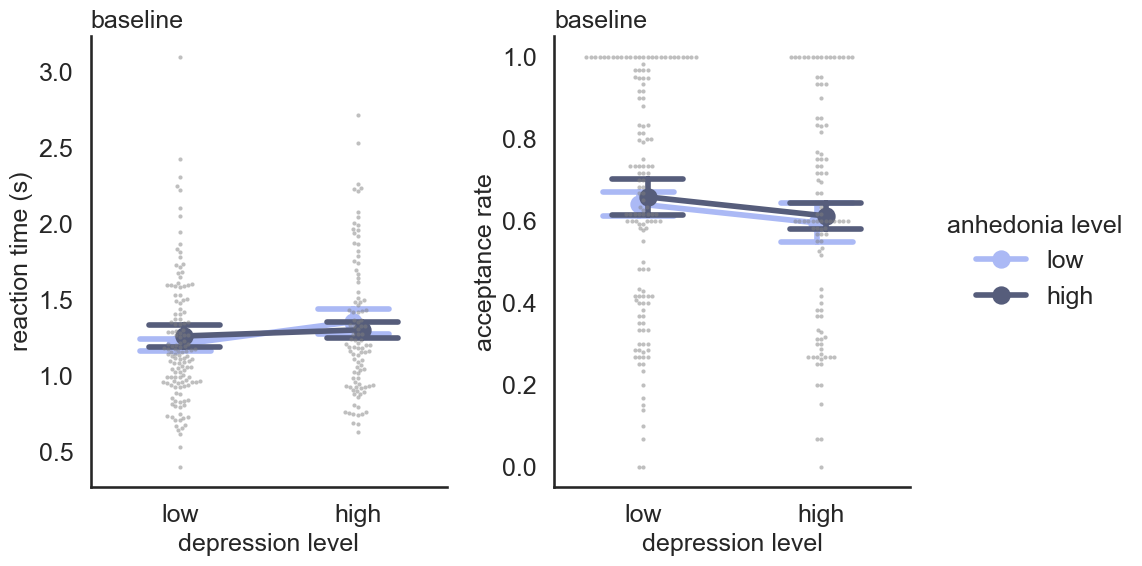

In [146]:
# Set style
sns.set(style='white', palette='colorblind')
sns.set_context('talk')  # Already increases base font size

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Shared font settings
title_fontsize = 18
label_fontsize = 18
tick_fontsize = 18
legend_fontsize = 18

# Panel a: Reaction Time
sns.swarmplot(data=ug_sub_t1, x='depression_level', y='choice_rt', ax=axes[0],
              color='grey', alpha=0.5, size=3)
sns.pointplot(data=ug_sub_t1, x='depression_level', y='choice_rt', hue='anhedonia_level',
              ax=axes[0], errorbar=('se', 1), palette=ug_palette,
              capsize=0.4, dodge=True, legend=False)
axes[0].set_title('baseline', loc='left', fontsize=title_fontsize)
axes[0].set_xlabel('depression level', fontsize=label_fontsize)
axes[0].set_ylabel('reaction time (s)', fontsize=label_fontsize)
axes[0].tick_params(labelsize=tick_fontsize)

# Panel b: Acceptance Rate
sns.swarmplot(data=ug_sub_t1, x='depression_level', y='choice_acc', ax=axes[1],
              color='grey', alpha=0.5, size=3)
sns.pointplot(data=ug_sub_t1, x='depression_level', y='choice_acc', hue='anhedonia_level',
              ax=axes[1], errorbar=('se', 1), palette=ug_palette,
              capsize=0.4, dodge=True, legend=True)
axes[1].set_title('baseline', loc='left', fontsize=title_fontsize)
axes[1].set_xlabel('depression level', fontsize=label_fontsize)
axes[1].set_ylabel('acceptance rate', fontsize=label_fontsize)
axes[1].tick_params(labelsize=tick_fontsize)

# Legend
axes[1].legend(title='anhedonia level', title_fontsize=legend_fontsize, fontsize=legend_fontsize,
    bbox_to_anchor=(1.35, 0.5), loc='center', borderaxespad=0, frameon=False)

plt.tight_layout()
sns.despine()
plt.savefig('./figure/fig_ug_beh_T1.jpg', dpi=300, bbox_inches='tight')
plt.show()

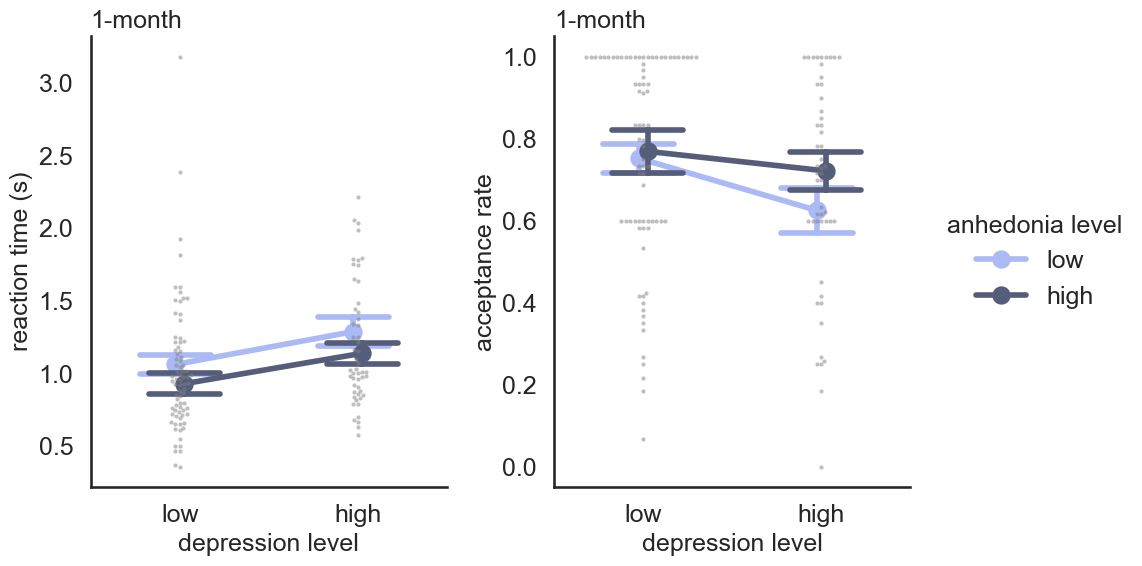

In [147]:
# Set style
sns.set(style='white', palette='colorblind')
sns.set_context('talk')  # Already increases base font size

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Panel a: Reaction Time
sns.swarmplot(data=ug_sub_t3, x='depression_level', y='choice_rt', ax=axes[0],
              color='grey', alpha=0.5, size=3)
sns.pointplot(data=ug_sub_t3, x='depression_level', y='choice_rt', hue='anhedonia_level',
              ax=axes[0], errorbar=('se', 1), palette=ug_palette,
              capsize=0.4, dodge=True, legend=False)
axes[0].set_title('1-month', loc='left', fontsize=title_fontsize)
axes[0].set_xlabel('depression level', fontsize=label_fontsize)
axes[0].set_ylabel('reaction time (s)', fontsize=label_fontsize)
axes[0].tick_params(labelsize=tick_fontsize)

# Panel b: Acceptance Rate
sns.swarmplot(data=ug_sub_t3, x='depression_level', y='choice_acc', ax=axes[1],
              color='grey', alpha=0.5, size=3)
sns.pointplot(data=ug_sub_t3, x='depression_level', y='choice_acc', hue='anhedonia_level',
              ax=axes[1], errorbar=('se', 1), palette=ug_palette,
              capsize=0.4, dodge=True, legend=True)
axes[1].set_title('1-month', loc='left', fontsize=title_fontsize)
axes[1].set_xlabel('depression level', fontsize=label_fontsize)
axes[1].set_ylabel('acceptance rate', fontsize=label_fontsize)
axes[1].tick_params(labelsize=tick_fontsize)

# Legend
axes[1].legend(title='anhedonia level', title_fontsize=legend_fontsize, fontsize=legend_fontsize,
    bbox_to_anchor=(1.35, 0.5), loc='center', borderaxespad=0, frameon=False)

plt.tight_layout()
sns.despine()
plt.savefig('./figure/fig_ug_beh_T3.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Figure 4
Figure 4 a-c    
UG computational parameter correlation

## UG model correlations 

In [2]:
# load winning varf0 models
ug_t1_fs = pd.read_csv('../ug_modeling/baseline_fit/UG_fit_RWvarf0_May25.csv')
ug_t3_fs = pd.read_csv('../ug_modeling/month1_fit/UG_fit_RWvarf0_T3_May25.csv')

In [3]:
# Get unique subject IDs from each session
t1_ids_param = set(ug_t1_fs['participant'].unique())
t3_ids_param = set(ug_t3_fs['participant'].unique())
# Find IDs present in both T1 and T3
common_ids_param = t1_ids_param.intersection(t3_ids_param)

In [4]:
# subset to common participants in all three timepoints
ug_t1_fs_common = ug_t1_fs[ug_t1_fs['participant'].isin(common_ids_param)].copy()
# ug_t2_fs_common = ug_t2_fs[ug_t2_fs['participant'].isin(common_ids_param)].copy()
ug_t3_fs_common = ug_t3_fs[ug_t3_fs['participant'].isin(common_ids_param)].copy()

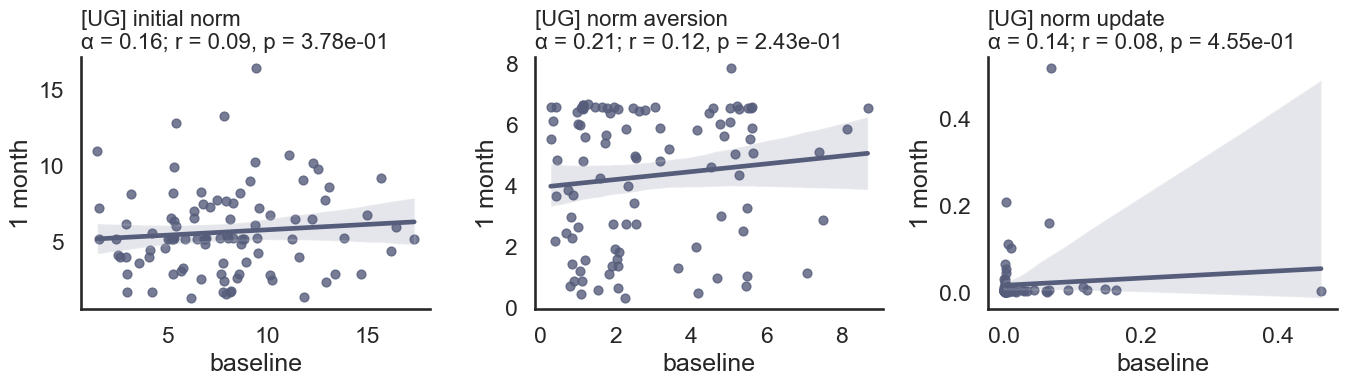

In [5]:
# Set a clean white style with no grid
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

# Merge T1 and T3 data on subject_id
merged = pd.merge(ug_t1_fs_common, ug_t3_fs_common, on='participant', suffixes=('_T1', '_T3'))
merged.dropna(inplace=True)

# Create figure and subplots with improved aspect ratio
fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))

# === Panel 1: initial norm ===
df_f0 = merged[['f0_T1', 'f0_T3']].dropna()
alpha_f0, _ = pg.cronbach_alpha(data=df_f0)
x_f0 = df_f0['f0_T1']
y_f0 = df_f0['f0_T3']
r_f0, p_f0 = pearsonr(x_f0, y_f0)
p_f0_text = f"p = {p_f0:.2e}"

sns.regplot(x=x_f0, y=y_f0, scatter_kws={"s": 40, "color": "#565d7b"},
            line_kws={"color": "#565d7b"}, ax=axes[0])
axes[0].set_title(f'[UG] initial norm \nα = {alpha_f0:.2f}; r = {r_f0:.2f}, {p_f0_text}',
                  fontsize=16, loc='left')
axes[0].set_xlabel('baseline')
axes[0].set_ylabel('1 month')

# === Panel 2: norm aversion ===
df_alpha = merged[['envy_T1', 'envy_T3']].dropna()
alpha_alpha, _ = pg.cronbach_alpha(data=df_alpha)
x_alpha = df_alpha['envy_T1']
y_alpha = df_alpha['envy_T3']
r_alpha, p_alpha = pearsonr(x_alpha, y_alpha)
p_alpha_text = f"p = {p_alpha:.2e}"

sns.regplot(x=x_alpha, y=y_alpha, scatter_kws={"s": 40, "color": "#565d7b"},
            line_kws={"color": "#565d7b"}, ax=axes[1])
axes[1].set_title(f'[UG] norm aversion \nα = {alpha_alpha:.2f}; r = {r_alpha:.2f}, {p_alpha_text}',
                  fontsize=16, loc='left')
axes[1].set_xlabel('baseline')
axes[1].set_ylabel('1 month')

# === Panel 3: inverse temperature ===
df_beta = merged[['lr_T1', 'lr_T3']].dropna()
alpha_beta, _ = pg.cronbach_alpha(data=df_beta)
x_beta = df_beta['lr_T1']
y_beta = df_beta['lr_T3']
r_beta, p_beta = pearsonr(x_beta, y_beta)
p_beta_text = f"p = {p_beta:.2e}"

sns.regplot(x=x_beta, y=y_beta, scatter_kws={"s": 40, "color": "#565d7b"},
            line_kws={"color": "#565d7b"}, ax=axes[2])
axes[2].set_title(f'[UG] norm update \nα = {alpha_beta:.2f}; r = {r_beta:.2f}, {p_beta_text}',
                  fontsize=16, loc='left')
axes[2].set_xlabel('baseline')
axes[2].set_ylabel('1 month')

# Final formatting and save
sns.despine()
plt.tight_layout()
# plt.savefig('./figure/ug_corr_param_T13.jpg', dpi=300, bbox_inches='tight')
plt.show()


df =  82


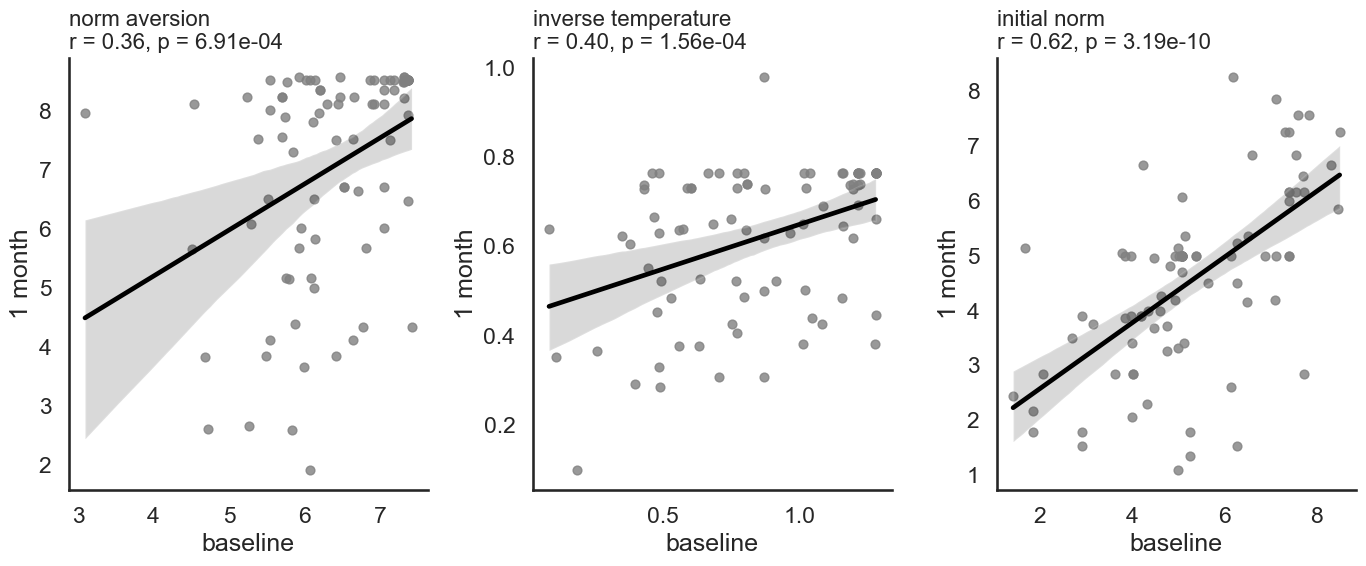

In [89]:
# Set a clean white style with no grid
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

# Merge T1 and T2 data on subject_id
merged = pd.merge(ug_t1_fs_common, ug_t3_fs_common, on='participant', suffixes=('_T1', '_T3'))
merged.dropna(inplace=True)

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# === Panel: norm aversion ===
x_alpha = merged['envy_T1']
y_alpha = merged['envy_T3']
r_alpha, p_alpha = pearsonr(x_alpha, y_alpha)
print('df = ', len(x_alpha) - 2)
p_alpha_text = f"p = {p_alpha:.2e}"

sns.regplot(x=x_alpha, y=y_alpha, scatter_kws={"s": 40, "color": "grey"}, line_kws={"color": "black"}, ax=axes[0])
axes[0].set_title(f'norm aversion \nr = {r_alpha:.2f}, {p_alpha_text}', fontsize=16, loc='left')
axes[0].set_xlabel('baseline')
axes[0].set_ylabel('1 month')

# === Panel: inverse temperature ===
x_beta = merged['beta_T1']
y_beta = merged['beta_T3']
r_beta, p_beta = pearsonr(x_beta, y_beta)
p_beta_text = f"p = {p_beta:.2e}"

sns.regplot(x=x_beta, y=y_beta, scatter_kws={"s": 40, "color": "grey"}, line_kws={"color": "black"}, ax=axes[1])
axes[1].set_title(f'inverse temperature \nr = {r_beta:.2f}, {p_beta_text}', fontsize=16, loc='left')
axes[1].set_xlabel('baseline')
axes[1].set_ylabel('1 month')

# === Panel: initial norm ===
x_f0 = merged['f0_T1']
y_f0 = merged['f0_T3']
r_f0, p_f0 = pearsonr(x_f0, y_f0)
p_f0_text = f"p = {p_f0:.2e}"

sns.regplot(x=x_f0, y=y_f0, scatter_kws={"s": 40, "color": "grey"}, line_kws={"color": "black"}, ax=axes[2])
axes[2].set_title(f'initial norm \nr = {r_f0:.2f}, {p_f0_text}', fontsize=16, loc='left')
axes[2].set_xlabel('baseline')
axes[2].set_ylabel('1 month')

# save
sns.despine()
plt.tight_layout()
plt.savefig('./figure/ug_corr_param_T13.jpg', dpi=300, bbox_inches='tight')
plt.show()

## RL model correlations

valence correlation, but 1-month wining changed to context 

In [75]:
# load winning baseline valence model
rl_t1_v = pd.read_csv('../rl_modeling/baseline_fit/RL_fit_RW_valence_T1_May25.csv')
rl_t3_v = pd.read_csv('../rl_modeling/month1_fit/RL_fit_RW_valence_T3_May25.csv')

In [76]:
# Get unique subject IDs from each session
t1_ids_param = set(rl_t1_v['participant'].unique())
t3_ids_param = set(rl_t3_v['participant'].unique())
# Find IDs present in both T1 and T3
common_ids_param = t1_ids_param.intersection(t3_ids_param)

In [77]:
# subset to common participants in all three timepoints
rl_t1_v_common = rl_t1_v[rl_t1_v['participant'].isin(common_ids_param)].copy()
rl_t3_v_common = rl_t3_v[rl_t3_v['participant'].isin(common_ids_param)].copy()

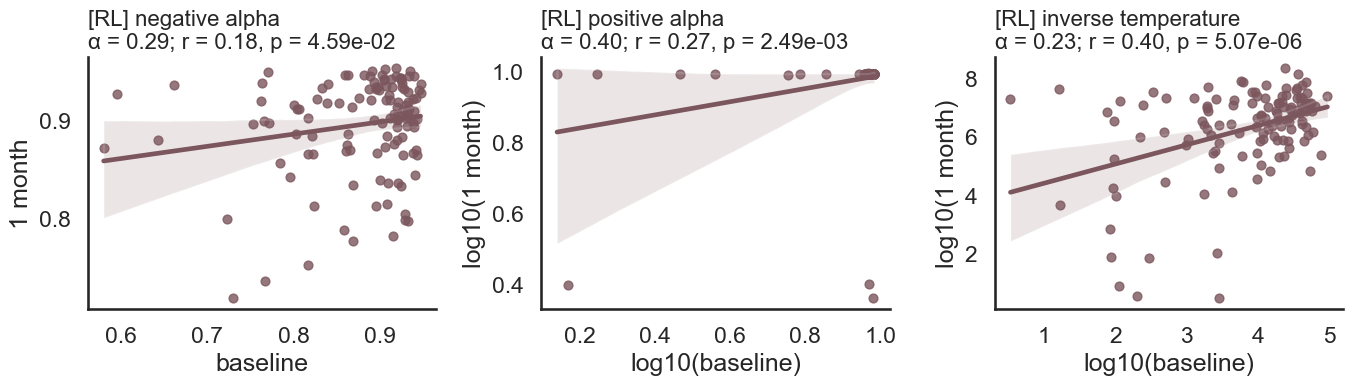

In [81]:
# Set a clean white style with no grid
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

# Merge T1 and T3 data on subject_id
merged = pd.merge(rl_t1_v_common, rl_t3_v_common, on='participant', suffixes=('_T1', '_T3'))
merged.dropna(inplace=True)

# Create figure and subplots with improved aspect ratio
fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))

# === Panel 1: initial norm ===
df_f0 = merged[['alpha_neg_T1', 'alpha_neg_T3']].dropna()
alpha_f0, _ = pg.cronbach_alpha(data=df_f0)
x_f0 = df_f0['alpha_neg_T1']
y_f0 = df_f0['alpha_neg_T3']
r_f0, p_f0 = pearsonr(x_f0, y_f0)
p_f0_text = f"p = {p_f0:.2e}"

sns.regplot(x=x_f0, y=y_f0, scatter_kws={"s": 40, "color": "#7b565d"},
            line_kws={"color": "#7b565d"}, ax=axes[0])
axes[0].set_title(f'[RL] negative alpha \nα = {alpha_f0:.2f}; r = {r_f0:.2f}, {p_f0_text}',
                  fontsize=16, loc='left')
axes[0].set_xlabel('baseline')
axes[0].set_ylabel('1 month')

# === Panel 2: norm aversion ===
df_alpha = merged[['alpha_pos_T1', 'alpha_pos_T3']].dropna()
alpha_alpha, _ = pg.cronbach_alpha(data=df_alpha)
# x_alpha = np.log10(df_alpha['alpha_pos_T1'])
# y_alpha = np.log10(df_alpha['alpha_pos_T3'])
x_alpha = df_alpha['alpha_pos_T1']
y_alpha = df_alpha['alpha_pos_T3']
r_alpha, p_alpha = pearsonr(x_alpha, y_alpha)
p_alpha_text = f"p = {p_alpha:.2e}"

sns.regplot(x=x_alpha, y=y_alpha, scatter_kws={"s": 40, "color": "#7b565d"},
            line_kws={"color": "#7b565d"}, ax=axes[1])
axes[1].set_title(f'[RL] positive alpha \nα = {alpha_alpha:.2f}; r = {r_alpha:.2f}, {p_alpha_text}',
                  fontsize=16, loc='left')
axes[1].set_xlabel('log10(baseline)')
axes[1].set_ylabel('log10(1 month)')

# === Panel 3: inverse temperature ===
df_beta = merged[['beta_T1', 'beta_T3']].dropna()
alpha_beta, _ = pg.cronbach_alpha(data=df_beta)
x_beta = np.log10(df_beta['beta_T1'])
y_beta = np.log10(df_beta['beta_T3'])
# x_beta = df_beta['beta_T1']
# y_beta = df_beta['beta_T3']
r_beta, p_beta = pearsonr(x_beta, y_beta)
p_beta_text = f"p = {p_beta:.2e}"

sns.regplot(x=x_beta, y=y_beta, scatter_kws={"s": 40, "color": "#7b565d"},
            line_kws={"color": "#7b565d"}, ax=axes[2])
axes[2].set_title(f'[RL] inverse temperature \nα = {alpha_beta:.2f}; r = {r_beta:.2f}, {p_beta_text}',
                  fontsize=16, loc='left')
axes[2].set_xlabel('log10(baseline)')
axes[2].set_ylabel('log10(1 month)')
axes[2].get_xaxis().get_offset_text().set_visible(False)
axes[2].get_yaxis().get_offset_text().set_visible(False)


# Final formatting and save
sns.despine()
plt.tight_layout()
# plt.savefig('./figure/ug_corr_param_T13.jpg', dpi=300, bbox_inches='tight')
plt.show()


In [82]:
df_alpha

,alpha_pos_T1,alpha_pos_T3
0,0.981994,0.992309
1,0.973001,0.992616
2,0.978824,0.993010
3,0.980194,0.992907
4,0.855794,0.992267
...,...,...
117,0.978607,0.992876
118,0.976378,0.992965
119,0.980020,0.992857
120,0.561107,0.992135


In [74]:
p_beta_text

'p = 5.07e-06'

## week archive

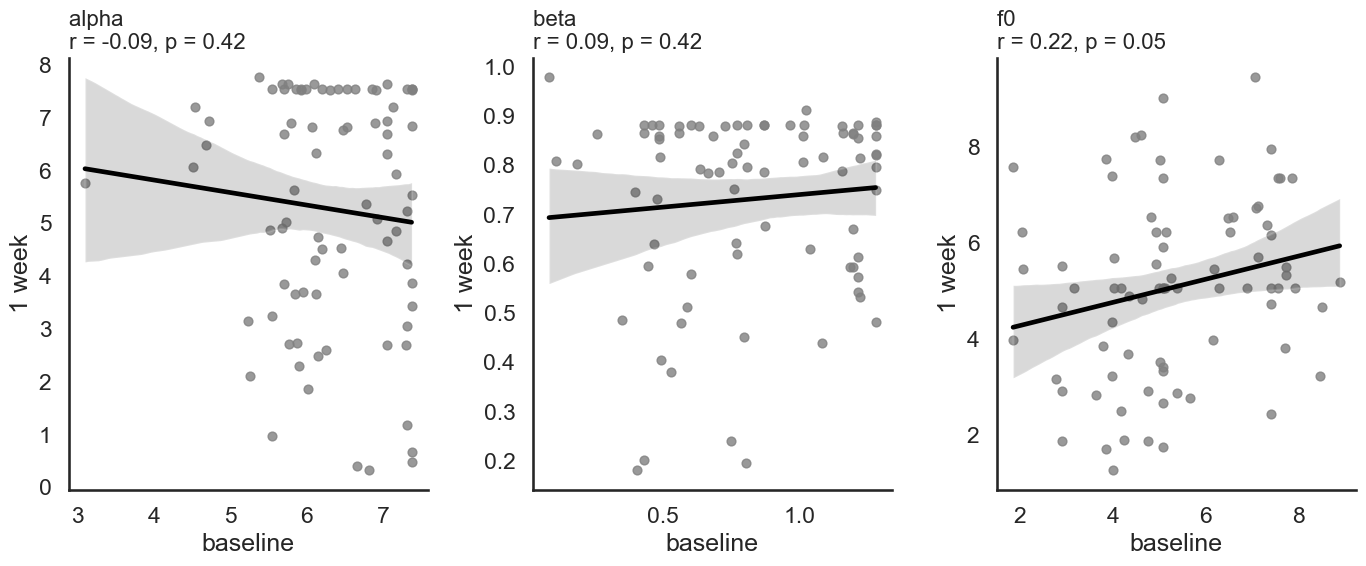

In [36]:
# Set a clean white style with no grid
sns.set(style='white', palette='colorblind')
sns.set_context('talk')

# Merge T1 and T2 data on subject_id
merged = pd.merge(ug_t1_fs_common, ug_t2_fs_common, on='participant', suffixes=('_T1', '_T2'))
merged.dropna(inplace=True)

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# === Panel d: norm aversion ===
x_rt = merged['envy_T1']
y_rt = merged['envy_T2']
r_rt, p_rt = pearsonr(x_rt, y_rt)
p_rt_text = "p < 0.01" if p_rt < 0.01 else f"p = {p_rt:.2f}"

sns.regplot(x=x_rt, y=y_rt, scatter_kws={"s": 40, "color": "grey"}, line_kws={"color": "black"}, ax=axes[0])
axes[0].set_title(f'alpha \nr = {r_rt:.2f}, {p_rt_text}', fontsize=16, loc='left')
# axes[0].set_title('a', fontsize=20, loc='left')
axes[0].set_xlabel('baseline')
axes[0].set_ylabel('1 week')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# === Panel e: inverse temperature ===
x_ca = merged['beta_T1']
y_ca = merged['beta_T2']
r_ca, p_ca = pearsonr(x_ca, y_ca)
p_ca_text = "p < 0.01" if p_ca < 0.01 else f"p = {p_ca:.2f}"

sns.regplot(x=x_ca, y=y_ca, scatter_kws={"s": 40, "color": "grey"}, line_kws={"color": "black"}, ax=axes[1])
axes[1].set_title(f'beta \nr = {r_ca:.2f}, {p_ca_text}', fontsize=16, loc='left')
axes[1].set_xlabel('baseline')
axes[1].set_ylabel('1 week')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# === Panel f: initial norm ===
x_m = merged['f0_T1']
y_m = merged['f0_T2']
r_m, p_m = pearsonr(x_m, y_m)
p_m_text = "p < 0.01" if p_m < 0.01 else f"p = {p_m:.2f}"

sns.regplot(x=x_m, y=y_m, scatter_kws={"s": 40, "color": "grey"}, line_kws={"color": "black"}, ax=axes[2])
axes[2].set_title(f'f0 \nr = {r_m:.2f}, {p_m_text}', fontsize=16, loc='left')
axes[2].set_xlabel('baseline')
axes[2].set_ylabel('1 week')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# save
plt.tight_layout()
# plt.savefig('./figure/psy_corr_beh_T12.jpg', dpi=300, bbox_inches='tight')
plt.show()